In [1]:
# basic
import numpy as np
import pandas as pd

# gnn and train
import tensorflow as tf

import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import gat_v2, graph_sage

# demo
import matplotlib.pyplot as plt

2023-01-24 09:06:40.517545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 09:06:40.669635: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-24 09:06:40.674771: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 09:06:40.674792: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# train_fp = './tfgnn_dataset/nexmark_isBP_train.tfrecord'
# val_fp = './tfgnn_dataset/nexmark_isBP_val.tfrecord'
# test_fp = './tfgnn_dataset/nexmark_isBP_test.tfrecord'
# schema_fp = './tfgnn_dataset/schema_poc.pbtxt'

train_fp = './tfgnn_dataset/nexmark_isBP_train_fixed.tfrecord'
val_fp = './tfgnn_dataset/nexmark_isBP_val_fixed.tfrecord'
test_fp = './tfgnn_dataset/nexmark_isBP_test_fixed.tfrecord'
schema_fp = './tfgnn_dataset/schema_poc.pbtxt'

In [63]:
# Read the dataset of tf.Example protos for training.
train_ds = tf.data.TFRecordDataset(filenames=[train_fp])
val_ds = tf.data.TFRecordDataset(filenames=[val_fp])
test_ds = tf.data.TFRecordDataset(filenames=[test_fp])
# Parse the GraphTensor values.
graph_schema = tfgnn.read_schema(schema_fp)
example_input_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema) # spec

In [64]:
def encode_fn(serialized):
    return tfgnn.parse_single_example(example_input_spec, serialized)

In [65]:
BATCH_SIZE = 256
train_ds = train_ds.map(encode_fn).shuffle(10000).batch(BATCH_SIZE)
val_ds = val_ds.map(encode_fn).batch(BATCH_SIZE)
test_ds = test_ds.map(encode_fn)

preproc_input_spec = train_ds.element_spec
preproc_input_spec

GraphTensorSpec({'context': ContextSpec({'features': {'label_isBP': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'bytes_input_rate': TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), 'records_input_rate': TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32)}, 'sizes': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)}, TensorShape([None]), tf.int32, None), 'operate': NodeSetSpec({'features': {'parallelism': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'bytes_selectivity': RaggedTensorSpec(TensorShape([None, None, 1]), tf.float32, 1, tf.int32), 'utilization_embedding': RaggedTensorSpec(TensorShape([None, None, 6]), tf.float32, 1, tf.int32), 'records_selectivity': RaggedTensorSpec(TensorS

In [66]:
# Define pre-process model for initial hidden states, actually all partial models
def node_sets_fn(node_set, *, node_set_name):
    if node_set_name == 'source':
        return node_set['parallelism']
    elif node_set_name == 'operate':
        stacked_non_embed = tf.keras.layers.Concatenate()([node_set['bytes_selectivity'], 
                                                           node_set['records_selectivity'], 
                                                           node_set['parallelism'],])
        return tf.keras.layers.Concatenate()([node_set['utilization_embedding'], 
                                              stacked_non_embed,])

def context_fn(context):
    stacked_cont = tf.keras.layers.Concatenate()([context['bytes_input_rate'], 
                                                  context['records_input_rate'],],)
    return {'hidden_state': stacked_cont,
            'label_isBP': context['label_isBP']}

def split_fn(graph):
    labels = tfgnn.keras.layers.Readout(from_context=True, 
                                        feature_name="label_isBP")(graph)
    graph = graph.remove_features(context=['label_isBP'])
    assert "label_isBP" not in graph.context.features
    return graph, labels

In [67]:
# Define and apply the preprocessing model. (now starts to define a graph model with the view of a scalar sample)
preproc_input = tf.keras.layers.Input(type_spec=preproc_input_spec)
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn, 
                                       context_fn=context_fn,)(preproc_input)  # With preprocessed features, see below.
graph = graph.merge_batch_to_components()  # See section "Merging a batch".
graph, labels = split_fn(graph) # See section "Splitting the label off ...".

preproc_model = tf.keras.Model(preproc_input, (graph, labels, )) # now we defined the pp-model
# above is just a defined computing process, the following is the process process on the whole dataset
train_ds = train_ds.map(preproc_model)
val_ds = val_ds.map(preproc_model)
test_ds = test_ds.map(preproc_model)

In [68]:
# assert list(graph.node_sets["operate"].keys()) == [tfgnn.HIDDEN_STATE]
# BUG: not working, use manual checking:
list(graph.node_sets['operate'].get_features_dict().keys()),list(graph.node_sets['source'].get_features_dict().keys())

(['hidden_state'], ['hidden_state'])

In [69]:
def dense(units, activation="relu"):
    """A Dense layer with regularization (L2 and Dropout)."""
    regularizer = tf.keras.regularizers.l2(5e-4)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units,
                              activation=activation,
                              kernel_regularizer=regularizer,
                              bias_regularizer=regularizer),
        tf.keras.layers.Dropout(0.1)])

def convolution(message_dim, receiver_tag):
    return tfgnn.keras.layers.SimpleConv(dense(message_dim), "mean",
                                         receiver_tag=receiver_tag)

def next_state(next_state_dim):
    return tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim))

In [70]:
# def MotherFuckerGraphUpdate_use(graph, units=5):
#     graph = tfgnn.keras.layers.GraphUpdate(
#         node_sets = {'source': tfgnn.keras.layers.NodeSetUpdate(
#                         {'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE), 
#                          'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.TARGET),},
#                         tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, 'relu')),
#                         context_input_feature=tfgnn.HIDDEN_STATE),
#                      'operate': tfgnn.keras.layers.NodeSetUpdate(
#                          {'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
#                           'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
#                           'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.TARGET),
#                           'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.TARGET),},
#                          tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, 'relu')),
#                          context_input_feature=tfgnn.HIDDEN_STATE),},
#         context = tfgnn.keras.layers.ContextUpdate( 
#             {'source': tfgnn.keras.layers.Pool(tfgnn.CONTEXT, 'mean'), 
#              'operate': tfgnn.keras.layers.Pool(tfgnn.CONTEXT, 'mean')},
#             tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units)))
#         )(graph)
#     return graph

# def MotherFuckerGraphUpdate_use(graph, units=5):
#     graph = tfgnn.keras.layers.GraphUpdate(
#         node_sets = {'operate': tfgnn.keras.layers.NodeSetUpdate(
#                          {
# #                           'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
#                           'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.TARGET),
# #                           'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
#                           'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.TARGET),
#                          },
#                          tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, 'relu')),
#                          context_input_feature=tfgnn.HIDDEN_STATE),
#                     },
#         context = tfgnn.keras.layers.ContextUpdate( 
#             {'operate': tfgnn.keras.layers.Pool(tfgnn.CONTEXT, 'mean')},
#             tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, 'relu')))
#         )(graph)
#     return graph

def MotherFuckerGraphUpdate_use(graph, units=5):
    message_width=2*units
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets = {'operate': tfgnn.keras.layers.NodeSetUpdate(
                         {
#                           'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
                          'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, activation='relu', use_bias=True,), 'mean', receiver_tag=tfgnn.TARGET),
#                           'src2op': gat_v2.GATv2Conv(2, units, receiver_tag=tfgnn.TARGET),
#                           'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
                          'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, activation='relu', use_bias=True,), 'mean', receiver_tag=tfgnn.TARGET),
#                           'op2op': gat_v2.GATv2Conv(2, units, receiver_tag=tfgnn.TARGET),
                         },
                         tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, activation='relu', use_bias=True,)),
                         context_input_feature=tfgnn.HIDDEN_STATE),
                    },
        context = tfgnn.keras.layers.ContextUpdate( 
            {'operate': tfgnn.keras.layers.Pool(tfgnn.CONTEXT, 'mean')},
            tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, activation='relu', use_bias=True,)))
        )(graph)
    return graph

def ReuseableGraphUpdate_use(graph, units=5):
    
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets = {'operate': tfgnn.keras.layers.NodeSetUpdate(
                         {
#                           'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
                          'src2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, activation='relu', use_bias=True,), 'mean', receiver_tag=tfgnn.TARGET),
#                           'src2op': gat_v2.GATv2Conv(2, units, receiver_tag=tfgnn.TARGET),
#                           'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, 'relu'), 'mean', receiver_tag=tfgnn.SOURCE),
                          'op2op': tfgnn.keras.layers.SimpleConv(tf.keras.layers.Dense(units, activation='relu', use_bias=True,), 'mean', receiver_tag=tfgnn.TARGET),
#                           'op2op': gat_v2.GATv2Conv(2, units, receiver_tag=tfgnn.TARGET),
                         },
                         tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, activation='relu', use_bias=True,)),
                         context_input_feature=tfgnn.HIDDEN_STATE),
                    },
        context = tfgnn.keras.layers.ContextUpdate( 
            {'operate': tfgnn.keras.layers.Pool(tfgnn.CONTEXT, 'mean')},
            tfgnn.keras.layers.NextStateFromConcat(tf.keras.layers.Dense(units, activation='relu', use_bias=True,)))
        )(graph)

In [71]:
# define gnn update logic (using gatv2)
# def gnn(graph):
#     for i in range(2):
#         graph = gat_v2.GATv2MPNNGraphUpdate(units=5, message_dim=4, num_heads=1, receiver_tag=tfgnn.SOURCE)(graph)
#         graph = gat_v2.GATv2MPNNGraphUpdate(units=5, message_dim=4, num_heads=1, receiver_tag=tfgnn.TARGET,)(graph)
#     return graph

def gnn(graph):
    for i in range(3):
        graph = MotherFuckerGraphUpdate_use(graph, units=20)
    return graph

In [72]:
model_input_spec, _, = train_ds.element_spec # Drop the spec for the labels.
model_input_spec

GraphTensorSpec({'context': ContextSpec({'features': {'hidden_state': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'operate': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'src2op': EdgeSetSpec({'features': {}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(None,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 'source', '#index.1': 

In [73]:
# Define and train the main model.
model_input = tf.keras.layers.Input(type_spec=model_input_spec)
graph = gnn(model_input) # apply gnn model
# Classifying each graph as a whole, based on an aggregation of the node states from one node set
pooled_features_s = tfgnn.keras.layers.Pool(tfgnn.CONTEXT, "mean", node_set_name="source")(graph)
pooled_features_op = tfgnn.keras.layers.Pool(tfgnn.CONTEXT, "mean", node_set_name="operate")(graph)
pooled_features = tf.keras.layers.concatenate([pooled_features_s, pooled_features_op, ]) # concat states of both sets

# logits = tf.keras.layers.Dense(1)(pooled_features) # output
logits = tf.keras.layers.Dense(1)(pooled_features_op) # output
# logits = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(logits) # sigmod for classification
# logits = tf.round(logits)

model = tf.keras.Model(model_input, logits) # make the model

# compile this model for binary classification
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [()]                      0         
                                                                 
 graph_update_9 (GraphUpdate  ()                       2100      
 )                                                               
                                                                 
 graph_update_10 (GraphUpdat  ()                       3700      
 e)                                                              
                                                                 
 graph_update_11 (GraphUpdat  ()                       3700      
 e)                                                              
                                                                 
 pool_21 (Pool)              (None, 20)                0         
                                                          

In [51]:
# train
history = model.fit(train_ds, 
                    epochs=4000, 
                    validation_data=val_ds,)

Epoch 1/4000
11/11 [==============================] - 4s 91ms/step - loss: 1355653.8750 - val_loss: 1052077.6250
Epoch 2/4000
11/11 [==============================] - 1s 40ms/step - loss: 679567.1250 - val_loss: 335678.5938
Epoch 3/4000
11/11 [==============================] - 1s 43ms/step - loss: 95077.7500 - val_loss: 13225.6357
Epoch 4/4000
11/11 [==============================] - 1s 38ms/step - loss: 23472.6367 - val_loss: 24630.3047
Epoch 5/4000
11/11 [==============================] - 1s 39ms/step - loss: 30514.2773 - val_loss: 25412.6348
Epoch 6/4000
11/11 [==============================] - 1s 38ms/step - loss: 28925.8574 - val_loss: 22122.1562
Epoch 7/4000
11/11 [==============================] - 1s 39ms/step - loss: 22712.1895 - val_loss: 13944.5449
Epoch 8/4000
11/11 [==============================] - 1s 44ms/step - loss: 13224.4697 - val_loss: 9297.7803
Epoch 9/4000
11/11 [==============================] - 1s 42ms/step - loss: 10417.0059 - val_loss: 8935.2568
Epoch 10/4000
1

Epoch 65/4000
11/11 [==============================] - 1s 38ms/step - loss: 3897.2319 - val_loss: 3637.4741
Epoch 66/4000
11/11 [==============================] - 1s 43ms/step - loss: 3661.9170 - val_loss: 3308.8418
Epoch 67/4000
11/11 [==============================] - 1s 38ms/step - loss: 3449.3567 - val_loss: 3036.9092
Epoch 68/4000
11/11 [==============================] - 1s 40ms/step - loss: 3311.8389 - val_loss: 3066.5088
Epoch 69/4000
11/11 [==============================] - 1s 39ms/step - loss: 3335.7930 - val_loss: 2871.0242
Epoch 70/4000
11/11 [==============================] - 1s 40ms/step - loss: 3069.4482 - val_loss: 2808.0850
Epoch 71/4000
11/11 [==============================] - 1s 41ms/step - loss: 3071.2700 - val_loss: 2619.9104
Epoch 72/4000
11/11 [==============================] - 1s 44ms/step - loss: 3499.9648 - val_loss: 3390.2031
Epoch 73/4000
11/11 [==============================] - 1s 41ms/step - loss: 3665.6626 - val_loss: 3572.6294
Epoch 74/4000
11/11 [=======

11/11 [==============================] - 1s 43ms/step - loss: 1207.6470 - val_loss: 1240.6531
Epoch 216/4000
11/11 [==============================] - 1s 44ms/step - loss: 4661.4561 - val_loss: 3585.3623
Epoch 217/4000
11/11 [==============================] - 1s 41ms/step - loss: 2049.0417 - val_loss: 745.1605
Epoch 218/4000
11/11 [==============================] - 1s 40ms/step - loss: 673.3796 - val_loss: 496.8550
Epoch 219/4000
11/11 [==============================] - 1s 40ms/step - loss: 1431.2955 - val_loss: 1482.6271
Epoch 220/4000
11/11 [==============================] - 1s 41ms/step - loss: 1991.3962 - val_loss: 3928.6235
Epoch 221/4000
11/11 [==============================] - 1s 43ms/step - loss: 3181.0010 - val_loss: 1344.5548
Epoch 222/4000
11/11 [==============================] - 1s 39ms/step - loss: 1899.1428 - val_loss: 595.2638
Epoch 223/4000
11/11 [==============================] - 1s 39ms/step - loss: 2335.6812 - val_loss: 1707.4967
Epoch 224/4000
11/11 [================

11/11 [==============================] - 1s 39ms/step - loss: 2530.1309 - val_loss: 2768.5984
Epoch 366/4000
11/11 [==============================] - 1s 40ms/step - loss: 1936.3083 - val_loss: 1797.9497
Epoch 367/4000
11/11 [==============================] - 1s 42ms/step - loss: 2067.6765 - val_loss: 3867.7625
Epoch 368/4000
11/11 [==============================] - 1s 39ms/step - loss: 3775.0796 - val_loss: 1013.0975
Epoch 369/4000
11/11 [==============================] - 1s 39ms/step - loss: 3482.6580 - val_loss: 3720.1685
Epoch 370/4000
11/11 [==============================] - 1s 40ms/step - loss: 2393.7883 - val_loss: 1370.6359
Epoch 371/4000
11/11 [==============================] - 1s 39ms/step - loss: 1258.4447 - val_loss: 848.5488
Epoch 372/4000
11/11 [==============================] - 1s 40ms/step - loss: 861.7872 - val_loss: 832.7270
Epoch 373/4000
11/11 [==============================] - 1s 40ms/step - loss: 3725.8945 - val_loss: 3418.0066
Epoch 374/4000
11/11 [===============

11/11 [==============================] - 1s 39ms/step - loss: 1823.5594 - val_loss: 2814.8757
Epoch 516/4000
11/11 [==============================] - 1s 40ms/step - loss: 2549.7991 - val_loss: 523.3743
Epoch 517/4000
11/11 [==============================] - 1s 40ms/step - loss: 1180.0436 - val_loss: 1861.4078
Epoch 518/4000
11/11 [==============================] - 1s 39ms/step - loss: 1991.5656 - val_loss: 3772.1252
Epoch 519/4000
11/11 [==============================] - 1s 40ms/step - loss: 3903.9612 - val_loss: 761.6093
Epoch 520/4000
11/11 [==============================] - 1s 39ms/step - loss: 1688.3187 - val_loss: 3982.8162
Epoch 521/4000
11/11 [==============================] - 1s 39ms/step - loss: 3390.4624 - val_loss: 658.4655
Epoch 522/4000
11/11 [==============================] - 1s 39ms/step - loss: 1340.5085 - val_loss: 1530.7118
Epoch 523/4000
11/11 [==============================] - 1s 38ms/step - loss: 2100.9604 - val_loss: 4783.6802
Epoch 524/4000
11/11 [===============

11/11 [==============================] - 1s 39ms/step - loss: 449.3194 - val_loss: 354.8985
Epoch 666/4000
11/11 [==============================] - 1s 38ms/step - loss: 3074.9036 - val_loss: 3099.0874
Epoch 667/4000
11/11 [==============================] - 1s 39ms/step - loss: 2239.4744 - val_loss: 2458.0332
Epoch 668/4000
11/11 [==============================] - 1s 39ms/step - loss: 2321.8940 - val_loss: 898.4435
Epoch 669/4000
11/11 [==============================] - 1s 39ms/step - loss: 1458.5459 - val_loss: 1465.6427
Epoch 670/4000
11/11 [==============================] - 1s 38ms/step - loss: 2790.5271 - val_loss: 1298.2218
Epoch 671/4000
11/11 [==============================] - 1s 40ms/step - loss: 1406.9591 - val_loss: 1070.8700
Epoch 672/4000
11/11 [==============================] - 1s 39ms/step - loss: 1980.0272 - val_loss: 2291.5435
Epoch 673/4000
11/11 [==============================] - 1s 39ms/step - loss: 2344.9641 - val_loss: 3979.4919
Epoch 674/4000
11/11 [===============

11/11 [==============================] - 1s 40ms/step - loss: 1299.4010 - val_loss: 1321.7267
Epoch 816/4000
11/11 [==============================] - 1s 44ms/step - loss: 1731.4694 - val_loss: 477.3111
Epoch 817/4000
11/11 [==============================] - 1s 40ms/step - loss: 999.5084 - val_loss: 1429.6879
Epoch 818/4000
11/11 [==============================] - 1s 39ms/step - loss: 1471.2570 - val_loss: 1029.1537
Epoch 819/4000
11/11 [==============================] - 1s 39ms/step - loss: 1302.1123 - val_loss: 352.5032
Epoch 820/4000
11/11 [==============================] - 1s 41ms/step - loss: 1066.7059 - val_loss: 1530.9321
Epoch 821/4000
11/11 [==============================] - 1s 43ms/step - loss: 2981.1584 - val_loss: 980.5012
Epoch 822/4000
11/11 [==============================] - 1s 43ms/step - loss: 2064.0544 - val_loss: 1796.8187
Epoch 823/4000
11/11 [==============================] - 1s 43ms/step - loss: 1830.9446 - val_loss: 2103.3535
Epoch 824/4000
11/11 [================

Epoch 891/4000
11/11 [==============================] - 1s 39ms/step - loss: 849.5574 - val_loss: 217.5288
Epoch 892/4000
11/11 [==============================] - 1s 39ms/step - loss: 246.4792 - val_loss: 163.6649
Epoch 893/4000
11/11 [==============================] - 1s 40ms/step - loss: 579.0627 - val_loss: 703.8738
Epoch 894/4000
11/11 [==============================] - 1s 39ms/step - loss: 2033.9106 - val_loss: 695.4733
Epoch 895/4000
11/11 [==============================] - 1s 38ms/step - loss: 1109.2180 - val_loss: 545.7350
Epoch 896/4000
11/11 [==============================] - 1s 39ms/step - loss: 1374.6398 - val_loss: 473.1469
Epoch 897/4000
11/11 [==============================] - 1s 39ms/step - loss: 1497.3363 - val_loss: 925.3810
Epoch 898/4000
11/11 [==============================] - 1s 40ms/step - loss: 1063.2242 - val_loss: 945.7458
Epoch 899/4000
11/11 [==============================] - 1s 43ms/step - loss: 1848.5392 - val_loss: 1791.1613
Epoch 900/4000
11/11 [========

11/11 [==============================] - 1s 39ms/step - loss: 1424.8546 - val_loss: 404.5467
Epoch 1042/4000
11/11 [==============================] - 1s 39ms/step - loss: 2106.4651 - val_loss: 2960.6423
Epoch 1043/4000
11/11 [==============================] - 1s 39ms/step - loss: 1696.3877 - val_loss: 388.1501
Epoch 1044/4000
11/11 [==============================] - 1s 39ms/step - loss: 864.0253 - val_loss: 2591.5176
Epoch 1045/4000
11/11 [==============================] - 1s 42ms/step - loss: 3564.3254 - val_loss: 1089.6051
Epoch 1046/4000
11/11 [==============================] - 1s 41ms/step - loss: 1513.6188 - val_loss: 414.3343
Epoch 1047/4000
11/11 [==============================] - 1s 41ms/step - loss: 1613.2299 - val_loss: 801.3346
Epoch 1048/4000
11/11 [==============================] - 1s 39ms/step - loss: 1985.5239 - val_loss: 2177.4387
Epoch 1049/4000
11/11 [==============================] - 1s 38ms/step - loss: 1494.7021 - val_loss: 1015.7535
Epoch 1050/4000
11/11 [========

11/11 [==============================] - 1s 42ms/step - loss: 2913.8784 - val_loss: 3252.6423
Epoch 1117/4000
11/11 [==============================] - 1s 39ms/step - loss: 2421.2856 - val_loss: 1280.9779
Epoch 1118/4000
11/11 [==============================] - 1s 39ms/step - loss: 1273.8898 - val_loss: 1718.1027
Epoch 1119/4000
11/11 [==============================] - 1s 41ms/step - loss: 1470.9000 - val_loss: 1833.5261
Epoch 1120/4000
11/11 [==============================] - 1s 41ms/step - loss: 1639.8505 - val_loss: 652.6412
Epoch 1121/4000
11/11 [==============================] - 1s 40ms/step - loss: 673.0865 - val_loss: 231.7246
Epoch 1122/4000
11/11 [==============================] - 1s 40ms/step - loss: 1564.0522 - val_loss: 3364.7434
Epoch 1123/4000
11/11 [==============================] - 1s 40ms/step - loss: 2716.5540 - val_loss: 567.1959
Epoch 1124/4000
11/11 [==============================] - 1s 39ms/step - loss: 1307.7177 - val_loss: 1575.1014
Epoch 1125/4000
11/11 [=======

11/11 [==============================] - 1s 38ms/step - loss: 3657.5420 - val_loss: 1764.2219
Epoch 1192/4000
11/11 [==============================] - 1s 40ms/step - loss: 922.2116 - val_loss: 239.6459
Epoch 1193/4000
11/11 [==============================] - 1s 43ms/step - loss: 317.1171 - val_loss: 194.6185
Epoch 1194/4000
11/11 [==============================] - 1s 41ms/step - loss: 254.3935 - val_loss: 157.8159
Epoch 1195/4000
11/11 [==============================] - 1s 40ms/step - loss: 2459.7175 - val_loss: 3413.1089
Epoch 1196/4000
11/11 [==============================] - 1s 39ms/step - loss: 2307.0579 - val_loss: 283.4512
Epoch 1197/4000
11/11 [==============================] - 1s 39ms/step - loss: 2554.5876 - val_loss: 2333.1377
Epoch 1198/4000
11/11 [==============================] - 1s 39ms/step - loss: 1791.9161 - val_loss: 1199.4979
Epoch 1199/4000
11/11 [==============================] - 1s 39ms/step - loss: 2249.2097 - val_loss: 2912.7654
Epoch 1200/4000
11/11 [==========

11/11 [==============================] - 1s 43ms/step - loss: 704.4760 - val_loss: 811.5761
Epoch 1267/4000
11/11 [==============================] - 1s 43ms/step - loss: 2701.0452 - val_loss: 1416.5869
Epoch 1268/4000
11/11 [==============================] - 1s 40ms/step - loss: 1198.2272 - val_loss: 1877.3955
Epoch 1269/4000
11/11 [==============================] - 1s 39ms/step - loss: 1480.7406 - val_loss: 559.9226
Epoch 1270/4000
11/11 [==============================] - 1s 41ms/step - loss: 2237.2742 - val_loss: 3484.6699
Epoch 1271/4000
11/11 [==============================] - 1s 41ms/step - loss: 2488.3538 - val_loss: 1410.0898
Epoch 1272/4000
11/11 [==============================] - 1s 40ms/step - loss: 6623.8550 - val_loss: 6516.9683
Epoch 1273/4000
11/11 [==============================] - 1s 39ms/step - loss: 5157.4116 - val_loss: 1747.1729
Epoch 1274/4000
11/11 [==============================] - 1s 40ms/step - loss: 1284.3759 - val_loss: 1079.0917
Epoch 1275/4000
11/11 [======

11/11 [==============================] - 1s 39ms/step - loss: 2103.2590 - val_loss: 2601.5317
Epoch 1342/4000
11/11 [==============================] - 1s 42ms/step - loss: 1797.4355 - val_loss: 1107.4304
Epoch 1343/4000
11/11 [==============================] - 1s 42ms/step - loss: 1222.6333 - val_loss: 1661.4210
Epoch 1344/4000
11/11 [==============================] - 1s 41ms/step - loss: 1536.7150 - val_loss: 392.8163
Epoch 1345/4000
11/11 [==============================] - 1s 42ms/step - loss: 2244.9021 - val_loss: 2553.4451
Epoch 1346/4000
11/11 [==============================] - 1s 41ms/step - loss: 1955.2312 - val_loss: 1188.6879
Epoch 1347/4000
11/11 [==============================] - 1s 40ms/step - loss: 1031.6572 - val_loss: 847.9753
Epoch 1348/4000
11/11 [==============================] - 1s 41ms/step - loss: 1340.8726 - val_loss: 2132.5251
Epoch 1349/4000
11/11 [==============================] - 1s 40ms/step - loss: 1499.8240 - val_loss: 401.6284
Epoch 1350/4000
11/11 [======

11/11 [==============================] - 1s 41ms/step - loss: 1079.7943 - val_loss: 311.6291
Epoch 1417/4000
11/11 [==============================] - 1s 40ms/step - loss: 2434.8303 - val_loss: 2963.1895
Epoch 1418/4000
11/11 [==============================] - 1s 37ms/step - loss: 1809.6172 - val_loss: 533.1617
Epoch 1419/4000
11/11 [==============================] - 1s 40ms/step - loss: 1255.6178 - val_loss: 2702.4451
Epoch 1420/4000
11/11 [==============================] - 1s 40ms/step - loss: 2539.4683 - val_loss: 186.9075
Epoch 1421/4000
11/11 [==============================] - 1s 39ms/step - loss: 1144.3740 - val_loss: 1534.8799
Epoch 1422/4000
11/11 [==============================] - 1s 42ms/step - loss: 3187.4001 - val_loss: 2759.6572
Epoch 1423/4000
11/11 [==============================] - 1s 41ms/step - loss: 1635.4440 - val_loss: 1031.2432
Epoch 1424/4000
11/11 [==============================] - 1s 42ms/step - loss: 939.0292 - val_loss: 942.9741
Epoch 1425/4000
11/11 [========

11/11 [==============================] - 1s 40ms/step - loss: 1492.5615 - val_loss: 1061.5336
Epoch 1567/4000
11/11 [==============================] - 1s 40ms/step - loss: 1684.2482 - val_loss: 3480.0059
Epoch 1568/4000
11/11 [==============================] - 1s 40ms/step - loss: 857.2849 - val_loss: 1024.9152
Epoch 1569/4000
11/11 [==============================] - 1s 41ms/step - loss: 1267.7159 - val_loss: 1778.1885
Epoch 1570/4000
11/11 [==============================] - 1s 40ms/step - loss: 2602.0027 - val_loss: 711.3547
Epoch 1571/4000
11/11 [==============================] - 1s 40ms/step - loss: 2586.0417 - val_loss: 2663.5376
Epoch 1572/4000
11/11 [==============================] - 1s 39ms/step - loss: 2390.9902 - val_loss: 2205.5798
Epoch 1573/4000
11/11 [==============================] - 1s 40ms/step - loss: 2315.1604 - val_loss: 1580.3234
Epoch 1574/4000
11/11 [==============================] - 1s 40ms/step - loss: 3545.2229 - val_loss: 1920.8630
Epoch 1575/4000
11/11 [=====

11/11 [==============================] - 1s 40ms/step - loss: 915.5798 - val_loss: 422.6366
Epoch 1642/4000
11/11 [==============================] - 1s 38ms/step - loss: 1430.5201 - val_loss: 2529.2703
Epoch 1643/4000
11/11 [==============================] - 1s 41ms/step - loss: 1878.4919 - val_loss: 707.0266
Epoch 1644/4000
11/11 [==============================] - 1s 43ms/step - loss: 972.7355 - val_loss: 1841.7827
Epoch 1645/4000
11/11 [==============================] - 1s 41ms/step - loss: 2670.3586 - val_loss: 678.1603
Epoch 1646/4000
11/11 [==============================] - 1s 41ms/step - loss: 1747.8882 - val_loss: 1345.3438
Epoch 1647/4000
11/11 [==============================] - 1s 39ms/step - loss: 743.5480 - val_loss: 498.2041
Epoch 1648/4000
11/11 [==============================] - 1s 39ms/step - loss: 768.4366 - val_loss: 694.9315
Epoch 1649/4000
11/11 [==============================] - 1s 39ms/step - loss: 779.5044 - val_loss: 517.9243
Epoch 1650/4000
11/11 [==============

11/11 [==============================] - 1s 42ms/step - loss: 1256.1927 - val_loss: 2482.5247
Epoch 1792/4000
11/11 [==============================] - 1s 42ms/step - loss: 2340.6833 - val_loss: 258.5283
Epoch 1793/4000
11/11 [==============================] - 1s 41ms/step - loss: 1252.9135 - val_loss: 1226.2555
Epoch 1794/4000
11/11 [==============================] - 1s 39ms/step - loss: 1010.1644 - val_loss: 373.6945
Epoch 1795/4000
11/11 [==============================] - 1s 41ms/step - loss: 795.0833 - val_loss: 2123.8574
Epoch 1796/4000
11/11 [==============================] - 1s 41ms/step - loss: 1055.1608 - val_loss: 1897.9154
Epoch 1797/4000
11/11 [==============================] - 1s 43ms/step - loss: 2092.4260 - val_loss: 1271.6702
Epoch 1798/4000
11/11 [==============================] - 1s 42ms/step - loss: 1868.7301 - val_loss: 4102.8926
Epoch 1799/4000
11/11 [==============================] - 1s 41ms/step - loss: 4468.3882 - val_loss: 1493.7616
Epoch 1800/4000
11/11 [======

11/11 [==============================] - 1s 39ms/step - loss: 294.3188 - val_loss: 287.5073
Epoch 1867/4000
11/11 [==============================] - 1s 40ms/step - loss: 333.7517 - val_loss: 204.1215
Epoch 1868/4000
11/11 [==============================] - 1s 40ms/step - loss: 194.7273 - val_loss: 82.8153
Epoch 1869/4000
11/11 [==============================] - 1s 39ms/step - loss: 80.5317 - val_loss: 122.9047
Epoch 1870/4000
11/11 [==============================] - 1s 42ms/step - loss: 250.2062 - val_loss: 2108.9375
Epoch 1871/4000
11/11 [==============================] - 1s 41ms/step - loss: 4930.9033 - val_loss: 3756.9004
Epoch 1872/4000
11/11 [==============================] - 1s 40ms/step - loss: 2048.1733 - val_loss: 431.6314
Epoch 1873/4000
11/11 [==============================] - 1s 41ms/step - loss: 950.3507 - val_loss: 1181.7158
Epoch 1874/4000
11/11 [==============================] - 1s 40ms/step - loss: 1132.4042 - val_loss: 1039.5103
Epoch 1875/4000
11/11 [================

11/11 [==============================] - 1s 40ms/step - loss: 204.9515 - val_loss: 79.3865
Epoch 2017/4000
11/11 [==============================] - 1s 41ms/step - loss: 78.1329 - val_loss: 53.3460
Epoch 2018/4000
11/11 [==============================] - 1s 41ms/step - loss: 338.4211 - val_loss: 1410.7943
Epoch 2019/4000
11/11 [==============================] - 1s 39ms/step - loss: 1074.8823 - val_loss: 620.3377
Epoch 2020/4000
11/11 [==============================] - 1s 40ms/step - loss: 2447.1089 - val_loss: 1057.9661
Epoch 2021/4000
11/11 [==============================] - 1s 40ms/step - loss: 2534.8735 - val_loss: 3976.6919
Epoch 2022/4000
11/11 [==============================] - 1s 40ms/step - loss: 3273.9993 - val_loss: 591.4023
Epoch 2023/4000
11/11 [==============================] - 1s 40ms/step - loss: 3031.1663 - val_loss: 2624.6602
Epoch 2024/4000
11/11 [==============================] - 1s 40ms/step - loss: 1886.4950 - val_loss: 2288.7422
Epoch 2025/4000
11/11 [=============

11/11 [==============================] - 1s 41ms/step - loss: 77.9936 - val_loss: 116.1794
Epoch 2167/4000
11/11 [==============================] - 1s 40ms/step - loss: 711.3231 - val_loss: 2864.7341
Epoch 2168/4000
11/11 [==============================] - 1s 43ms/step - loss: 3782.5437 - val_loss: 1190.0166
Epoch 2169/4000
11/11 [==============================] - 1s 40ms/step - loss: 2741.7422 - val_loss: 4572.5796
Epoch 2170/4000
11/11 [==============================] - 1s 43ms/step - loss: 4247.1958 - val_loss: 912.6068
Epoch 2171/4000
11/11 [==============================] - 1s 45ms/step - loss: 733.1102 - val_loss: 514.8975
Epoch 2172/4000
11/11 [==============================] - 1s 46ms/step - loss: 789.7228 - val_loss: 748.5071
Epoch 2173/4000
11/11 [==============================] - 1s 44ms/step - loss: 1105.0913 - val_loss: 849.1612
Epoch 2174/4000
11/11 [==============================] - 1s 42ms/step - loss: 1498.8894 - val_loss: 4193.8735
Epoch 2175/4000
11/11 [=============

11/11 [==============================] - 1s 40ms/step - loss: 1070.0997 - val_loss: 1475.4196
Epoch 2317/4000
11/11 [==============================] - 1s 40ms/step - loss: 1775.3210 - val_loss: 327.8649
Epoch 2318/4000
11/11 [==============================] - 1s 41ms/step - loss: 743.0535 - val_loss: 1450.7140
Epoch 2319/4000
11/11 [==============================] - 1s 42ms/step - loss: 1107.3689 - val_loss: 170.9203
Epoch 2320/4000
11/11 [==============================] - 1s 42ms/step - loss: 142.8027 - val_loss: 78.6406
Epoch 2321/4000
11/11 [==============================] - 1s 40ms/step - loss: 77.3902 - val_loss: 90.9475
Epoch 2322/4000
11/11 [==============================] - 1s 40ms/step - loss: 72.0073 - val_loss: 82.6847
Epoch 2323/4000
11/11 [==============================] - 1s 40ms/step - loss: 308.8163 - val_loss: 1551.3496
Epoch 2324/4000
11/11 [==============================] - 1s 40ms/step - loss: 2062.3228 - val_loss: 1099.9939
Epoch 2325/4000
11/11 [==================

11/11 [==============================] - 1s 39ms/step - loss: 77.6517 - val_loss: 119.9419
Epoch 2467/4000
11/11 [==============================] - 1s 39ms/step - loss: 194.6087 - val_loss: 68.0286
Epoch 2468/4000
11/11 [==============================] - 1s 39ms/step - loss: 54.0744 - val_loss: 55.7512
Epoch 2469/4000
11/11 [==============================] - 1s 39ms/step - loss: 78.0027 - val_loss: 154.9343
Epoch 2470/4000
11/11 [==============================] - 1s 40ms/step - loss: 303.1326 - val_loss: 497.2565
Epoch 2471/4000
11/11 [==============================] - 1s 40ms/step - loss: 817.8760 - val_loss: 217.8038
Epoch 2472/4000
11/11 [==============================] - 1s 40ms/step - loss: 663.9691 - val_loss: 1479.3506
Epoch 2473/4000
11/11 [==============================] - 1s 40ms/step - loss: 1206.2889 - val_loss: 1914.0079
Epoch 2474/4000
11/11 [==============================] - 1s 40ms/step - loss: 2895.5857 - val_loss: 919.5762
Epoch 2475/4000
11/11 [======================

11/11 [==============================] - 1s 44ms/step - loss: 58.8559 - val_loss: 59.9669
Epoch 2617/4000
11/11 [==============================] - 1s 41ms/step - loss: 62.8213 - val_loss: 66.5838
Epoch 2618/4000
11/11 [==============================] - 1s 46ms/step - loss: 58.1506 - val_loss: 59.9011
Epoch 2619/4000
11/11 [==============================] - 1s 42ms/step - loss: 152.6922 - val_loss: 122.2849
Epoch 2620/4000
11/11 [==============================] - 1s 42ms/step - loss: 1441.8383 - val_loss: 1563.3710
Epoch 2621/4000
11/11 [==============================] - 1s 42ms/step - loss: 916.8972 - val_loss: 796.0894
Epoch 2622/4000
11/11 [==============================] - 1s 41ms/step - loss: 1013.6120 - val_loss: 1362.3942
Epoch 2623/4000
11/11 [==============================] - 1s 41ms/step - loss: 879.2274 - val_loss: 380.6006
Epoch 2624/4000
11/11 [==============================] - 1s 41ms/step - loss: 774.6576 - val_loss: 1823.7523
Epoch 2625/4000
11/11 [======================

11/11 [==============================] - 1s 42ms/step - loss: 1077.6929 - val_loss: 2536.2578
Epoch 2768/4000
11/11 [==============================] - 1s 43ms/step - loss: 2186.4124 - val_loss: 1610.3699
Epoch 2769/4000
11/11 [==============================] - 1s 43ms/step - loss: 3971.7456 - val_loss: 2354.1108
Epoch 2770/4000
11/11 [==============================] - 1s 43ms/step - loss: 1502.7980 - val_loss: 828.6887
Epoch 2771/4000
11/11 [==============================] - 1s 43ms/step - loss: 1144.2941 - val_loss: 2327.1748
Epoch 2772/4000
11/11 [==============================] - 1s 41ms/step - loss: 1934.9873 - val_loss: 1111.5522
Epoch 2773/4000
11/11 [==============================] - 1s 41ms/step - loss: 2597.9712 - val_loss: 1059.8790
Epoch 2774/4000
11/11 [==============================] - 1s 41ms/step - loss: 1713.5228 - val_loss: 1598.3788
Epoch 2775/4000
11/11 [==============================] - 1s 40ms/step - loss: 1029.7925 - val_loss: 732.3274
Epoch 2776/4000
11/11 [=====

Epoch 2918/4000
11/11 [==============================] - 1s 39ms/step - loss: 1065.6083 - val_loss: 398.0258
Epoch 2919/4000
11/11 [==============================] - 1s 40ms/step - loss: 683.1791 - val_loss: 296.5062
Epoch 2920/4000
11/11 [==============================] - 1s 41ms/step - loss: 299.5486 - val_loss: 379.7095
Epoch 2921/4000
11/11 [==============================] - 1s 39ms/step - loss: 439.4949 - val_loss: 261.5923
Epoch 2922/4000
11/11 [==============================] - 1s 40ms/step - loss: 1036.1608 - val_loss: 1232.3435
Epoch 2923/4000
11/11 [==============================] - 1s 39ms/step - loss: 2822.1233 - val_loss: 2657.8367
Epoch 2924/4000
11/11 [==============================] - 1s 40ms/step - loss: 1727.3083 - val_loss: 1920.5492
Epoch 2925/4000
11/11 [==============================] - 1s 40ms/step - loss: 2040.1489 - val_loss: 3833.9016
Epoch 2926/4000
11/11 [==============================] - 1s 40ms/step - loss: 1796.8844 - val_loss: 740.7796
Epoch 2927/4000
11

11/11 [==============================] - 1s 40ms/step - loss: 66.4583 - val_loss: 56.7366
Epoch 3070/4000
11/11 [==============================] - 1s 40ms/step - loss: 62.9614 - val_loss: 60.8153
Epoch 3071/4000
11/11 [==============================] - 1s 40ms/step - loss: 64.0997 - val_loss: 60.1425
Epoch 3072/4000
11/11 [==============================] - 1s 39ms/step - loss: 63.9725 - val_loss: 56.7794
Epoch 3073/4000
11/11 [==============================] - 1s 40ms/step - loss: 64.2072 - val_loss: 59.6005
Epoch 3074/4000
11/11 [==============================] - 1s 39ms/step - loss: 64.6751 - val_loss: 69.4224
Epoch 3075/4000
11/11 [==============================] - 1s 42ms/step - loss: 76.0208 - val_loss: 90.3410
Epoch 3076/4000
11/11 [==============================] - 1s 43ms/step - loss: 73.0252 - val_loss: 95.3080
Epoch 3077/4000
11/11 [==============================] - 1s 42ms/step - loss: 82.2583 - val_loss: 59.0374
Epoch 3078/4000
11/11 [==============================] - 1s 43

Epoch 3145/4000
11/11 [==============================] - 1s 41ms/step - loss: 401.5963 - val_loss: 210.2654
Epoch 3146/4000
11/11 [==============================] - 1s 41ms/step - loss: 190.8686 - val_loss: 113.9320
Epoch 3147/4000
11/11 [==============================] - 1s 40ms/step - loss: 111.0055 - val_loss: 133.2250
Epoch 3148/4000
11/11 [==============================] - 1s 40ms/step - loss: 286.3698 - val_loss: 101.1993
Epoch 3149/4000
11/11 [==============================] - 1s 39ms/step - loss: 162.3236 - val_loss: 127.4891
Epoch 3150/4000
11/11 [==============================] - 1s 40ms/step - loss: 154.3958 - val_loss: 91.9623
Epoch 3151/4000
11/11 [==============================] - 1s 40ms/step - loss: 92.8795 - val_loss: 63.9344
Epoch 3152/4000
11/11 [==============================] - 1s 40ms/step - loss: 74.4552 - val_loss: 102.3795
Epoch 3153/4000
11/11 [==============================] - 1s 42ms/step - loss: 789.2887 - val_loss: 1875.4283
Epoch 3154/4000
11/11 [========

Epoch 3296/4000
11/11 [==============================] - 1s 40ms/step - loss: 324.3830 - val_loss: 255.3023
Epoch 3297/4000
11/11 [==============================] - 1s 40ms/step - loss: 364.3836 - val_loss: 229.9866
Epoch 3298/4000
11/11 [==============================] - 1s 40ms/step - loss: 286.0014 - val_loss: 149.6563
Epoch 3299/4000
11/11 [==============================] - 1s 40ms/step - loss: 155.9289 - val_loss: 83.4080
Epoch 3300/4000
11/11 [==============================] - 1s 40ms/step - loss: 87.2581 - val_loss: 84.8218
Epoch 3301/4000
11/11 [==============================] - 1s 40ms/step - loss: 76.6497 - val_loss: 83.7190
Epoch 3302/4000
11/11 [==============================] - 1s 41ms/step - loss: 73.5590 - val_loss: 66.6550
Epoch 3303/4000
11/11 [==============================] - 1s 40ms/step - loss: 67.7373 - val_loss: 100.0776
Epoch 3304/4000
11/11 [==============================] - 1s 41ms/step - loss: 109.5110 - val_loss: 71.3492
Epoch 3305/4000
11/11 [==============

11/11 [==============================] - 1s 42ms/step - loss: 92.7513 - val_loss: 112.7237
Epoch 3373/4000
11/11 [==============================] - 1s 40ms/step - loss: 121.4732 - val_loss: 89.6895
Epoch 3374/4000
11/11 [==============================] - 1s 40ms/step - loss: 155.1483 - val_loss: 463.0377
Epoch 3375/4000
11/11 [==============================] - 1s 41ms/step - loss: 981.8226 - val_loss: 2807.4756
Epoch 3376/4000
11/11 [==============================] - 1s 40ms/step - loss: 2937.3518 - val_loss: 340.9737
Epoch 3377/4000
11/11 [==============================] - 1s 41ms/step - loss: 1572.8405 - val_loss: 1069.4325
Epoch 3378/4000
11/11 [==============================] - 1s 41ms/step - loss: 1002.4529 - val_loss: 743.0895
Epoch 3379/4000
11/11 [==============================] - 1s 45ms/step - loss: 775.4028 - val_loss: 880.8435
Epoch 3380/4000
11/11 [==============================] - 1s 43ms/step - loss: 1397.4034 - val_loss: 2823.4473
Epoch 3381/4000
11/11 [================

11/11 [==============================] - 1s 40ms/step - loss: 1506.4117 - val_loss: 3352.4529
Epoch 3524/4000
11/11 [==============================] - 1s 41ms/step - loss: 3553.1338 - val_loss: 439.8730
Epoch 3525/4000
11/11 [==============================] - 1s 41ms/step - loss: 909.2621 - val_loss: 120.6851
Epoch 3526/4000
11/11 [==============================] - 1s 43ms/step - loss: 2262.0105 - val_loss: 1790.1835
Epoch 3527/4000
11/11 [==============================] - 1s 41ms/step - loss: 708.7048 - val_loss: 94.5368
Epoch 3528/4000
11/11 [==============================] - 1s 43ms/step - loss: 149.5034 - val_loss: 103.5005
Epoch 3529/4000
11/11 [==============================] - 1s 42ms/step - loss: 114.9154 - val_loss: 77.2698
Epoch 3530/4000
11/11 [==============================] - 1s 40ms/step - loss: 77.6814 - val_loss: 92.8012
Epoch 3531/4000
11/11 [==============================] - 1s 42ms/step - loss: 80.5605 - val_loss: 79.3032
Epoch 3532/4000
11/11 [======================

11/11 [==============================] - 1s 40ms/step - loss: 75.2308 - val_loss: 98.3372
Epoch 3675/4000
11/11 [==============================] - 1s 40ms/step - loss: 75.2899 - val_loss: 78.8141
Epoch 3676/4000
11/11 [==============================] - 1s 41ms/step - loss: 70.5387 - val_loss: 72.9240
Epoch 3677/4000
11/11 [==============================] - 1s 40ms/step - loss: 72.5460 - val_loss: 82.0828
Epoch 3678/4000
11/11 [==============================] - 1s 39ms/step - loss: 84.4298 - val_loss: 92.4082
Epoch 3679/4000
11/11 [==============================] - 1s 39ms/step - loss: 79.1262 - val_loss: 84.3367
Epoch 3680/4000
11/11 [==============================] - 1s 42ms/step - loss: 72.8816 - val_loss: 83.7773
Epoch 3681/4000
11/11 [==============================] - 1s 40ms/step - loss: 80.6876 - val_loss: 75.2871
Epoch 3682/4000
11/11 [==============================] - 1s 41ms/step - loss: 90.1720 - val_loss: 73.7764
Epoch 3683/4000
11/11 [==============================] - 1s 40

11/11 [==============================] - 1s 41ms/step - loss: 106.4604 - val_loss: 91.0239
Epoch 3827/4000
11/11 [==============================] - 1s 41ms/step - loss: 85.0072 - val_loss: 111.5401
Epoch 3828/4000
11/11 [==============================] - 1s 39ms/step - loss: 89.1476 - val_loss: 89.1962
Epoch 3829/4000
11/11 [==============================] - 1s 40ms/step - loss: 77.2599 - val_loss: 77.7229
Epoch 3830/4000
11/11 [==============================] - 1s 41ms/step - loss: 68.0088 - val_loss: 75.3999
Epoch 3831/4000
11/11 [==============================] - 1s 40ms/step - loss: 76.0362 - val_loss: 69.4320
Epoch 3832/4000
11/11 [==============================] - 1s 40ms/step - loss: 77.2746 - val_loss: 87.7785
Epoch 3833/4000
11/11 [==============================] - 1s 41ms/step - loss: 270.6807 - val_loss: 598.2506
Epoch 3834/4000
11/11 [==============================] - 1s 41ms/step - loss: 2112.6570 - val_loss: 5804.5903
Epoch 3835/4000
11/11 [==============================]

11/11 [==============================] - 1s 40ms/step - loss: 2533.9036 - val_loss: 951.7307
Epoch 3979/4000
11/11 [==============================] - 1s 40ms/step - loss: 2048.0386 - val_loss: 2767.9666
Epoch 3980/4000
11/11 [==============================] - 1s 38ms/step - loss: 1898.1530 - val_loss: 1733.2584
Epoch 3981/4000
11/11 [==============================] - 1s 41ms/step - loss: 2408.8376 - val_loss: 300.8470
Epoch 3982/4000
11/11 [==============================] - 1s 40ms/step - loss: 1235.4906 - val_loss: 974.7896
Epoch 3983/4000
11/11 [==============================] - 1s 41ms/step - loss: 1458.7810 - val_loss: 3125.5203
Epoch 3984/4000
11/11 [==============================] - 1s 41ms/step - loss: 2771.8804 - val_loss: 1474.5448
Epoch 3985/4000
11/11 [==============================] - 1s 39ms/step - loss: 997.4752 - val_loss: 380.0869
Epoch 3986/4000
11/11 [==============================] - 1s 41ms/step - loss: 2072.4678 - val_loss: 2011.0682
Epoch 3987/4000
11/11 [========

### training results analysis

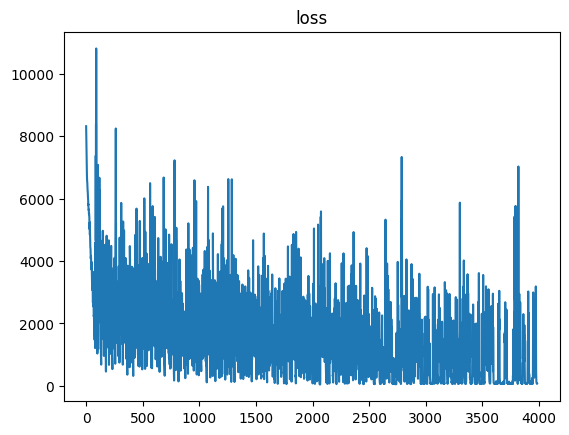

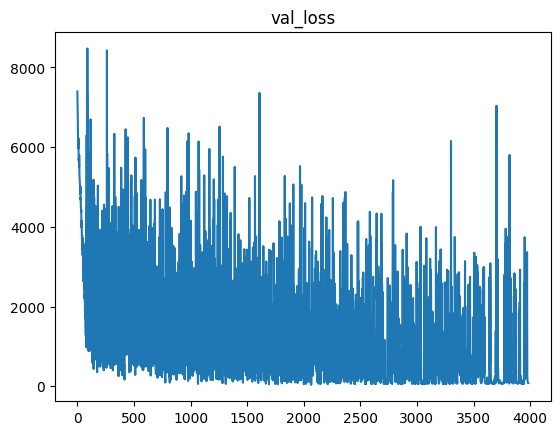

In [96]:
for k, hist in history.history.items():
    plt.plot(hist[15:])
    plt.title(k)
    plt.show()

In [53]:
test_predict_res = model.predict(test_ds)
# model.evaluate(test_ds)

597/597 [==============================] - 2s 3ms/step


In [54]:
test_predict_res

array([[-6.66797546e+02],
       [-1.50347705e+03],
       [-3.08711151e+02],
       [-6.59434875e+02],
       [ 9.49560840e+03],
       [ 5.64296631e+03],
       [ 1.17176182e+04],
       [ 4.27723572e+02],
       [-3.32856958e+03],
       [-3.00245972e+03],
       [-2.07801001e+03],
       [-9.43347961e+02],
       [-5.22696960e+02],
       [-2.95577710e+03],
       [-1.56130835e+03],
       [ 5.43119336e+03],
       [ 3.13067413e+02],
       [-2.96751685e+03],
       [-2.23275439e+03],
       [ 7.23586670e+02],
       [-8.59619751e+02],
       [ 2.48014206e+02],
       [ 1.30134219e+04],
       [-3.25576074e+03],
       [-3.12867310e+03],
       [-1.62136035e+03],
       [ 1.10480068e+04],
       [-3.02770850e+03],
       [ 9.07105938e+04],
       [ 9.59811523e+03],
       [ 2.39013770e+04],
       [ 4.48011055e+04],
       [-2.07072949e+03],
       [-2.18536560e+02],
       [-1.16559290e+03],
       [-1.94543640e+03],
       [ 9.90483765e+02],
       [ 3.47539990e+03],
       [-1.0

In [55]:
def binarize_res(pred_res, thres=0.5, from_logits=False):
    res = []
    for y_pred in pred_res:
        prob = y_pred if not from_logits else tf.nn.sigmoid(y_pred)
#         print(y_pred, tf.nn.sigmoid(y_pred))
        res.append( 1 if prob >= thres else 0)
    return res

In [56]:
binary_test_p_res = binarize_res(test_predict_res, thres=0.5, from_logits=False)
# len(binary_test_p_res), binary_test_p_res

In [57]:
test_ds_2 = tf.data.TFRecordDataset(filenames=[test_fp])
test_ds_2 = test_ds_2.map(encode_fn)
# label fetch model:
preproc_input_2 = tf.keras.layers.Input(type_spec=preproc_input_spec)
graph, labels = split_fn(preproc_input_2) # See section "Splitting the label off ...".
label_fetch_model = tf.keras.Model(preproc_input_2,  labels, )
# fetch
test_labels = test_ds_2.map(label_fetch_model)

In [58]:
y_true = np.array([e[0] for e in test_labels.as_numpy_iterator()])

In [59]:
def compute_accuracy(y_pred, y_true):
    l = len(y_pred)
    assert len(y_true) == l, 'diff len cannot do'
#     print(y_pred, y_true)
    return np.mean(y_pred == y_true)

def metrics(y_pred, y_true):
    acc = compute_accuracy(y_pred, y_true)
    tp,tn,fp,fn = 0,0,0,0
    
    l = len(y_pred)
    for i in range(l):
        p = y_pred[i]
        t = y_true[i]
        if p==t:
            if p == 1:
                tp += 1
            else:
                tn += 1
        elif p == 1:
            fp += 1
        else:
            fn += 1
    return (acc, tp/l, tn/l, fp/l, fn/l)

In [60]:
metrics(binary_test_p_res, y_true, )

(0.9212730318257957,
 0.4438860971524288,
 0.47738693467336685,
 0.01507537688442211,
 0.06365159128978225)

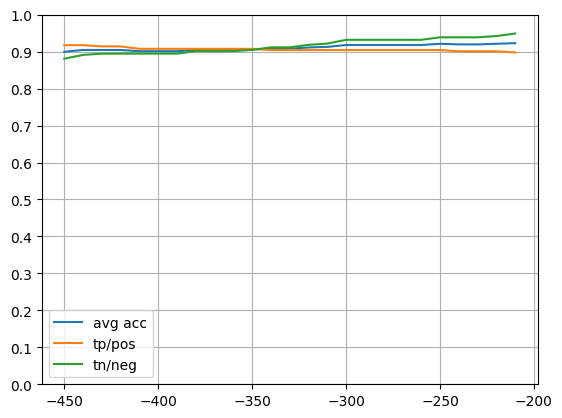

In [94]:
accs = []
tp_rate = []
fp_rate = []
pos_rate = np.mean(y_true)
threses = []

arange = np.arange(-45000, -20000, 1000)
for i in arange:
    thres = i/100
    binary_test_p_res = binarize_res(test_predict_res, thres=thres, from_logits=False)
    a, tp, tn, fp, fn = metrics(binary_test_p_res, y_true)
    accs.append(a)
    tp_rate.append(tp/pos_rate)
    fp_rate.append(tn/(1-pos_rate))
    threses.append(thres)

plt.plot(threses, accs, label='avg acc')
plt.plot(threses, tp_rate, label='tp/pos')
plt.plot(threses, fp_rate, label='tn/neg')

plt.yticks(np.arange(0,1.1,0.1))
# plt.xticks(np.arange(0,1.1,0.05))

plt.grid()
plt.legend()
plt.show()

In [85]:
binary_test_p_res = binarize_res(test_predict_res, thres=-350, from_logits=False)
metrics(binary_test_p_res, y_true)

(0.9061976549413735,
 0.46063651591289784,
 0.4455611390284757,
 0.04690117252931323,
 0.04690117252931323)

In [89]:
binary_test_p_res = binarize_res(test_predict_res, thres=-250, from_logits=False)
metrics(binary_test_p_res, y_true)

(0.9212730318257957,
 0.45896147403685095,
 0.4623115577889447,
 0.03015075376884422,
 0.048576214405360134)

In [163]:
# input()

In [164]:
# binary_test_p_res

In [51]:
agtensor = test_ds.take(1)

In [52]:
model.predict(agtensor)

1/1 [==============================] - 0s 205ms/step


array([[-244.86552]], dtype=float32)

## Exporting the model

#### export the whole model: serilizable -> logits/probs

In [95]:
# Export the combined SavedModel for serving.
model_save_path = "./tfgnn_model/exported_keras_model_1_24"
# first for the pre-processing model
serving_input = tf.keras.layers.Input(shape=[],  # The batch dim is implied.
                                      dtype=tf.string, name="examples")
preproc_input = tfgnn.keras.layers.ParseExample(example_input_spec)(serving_input)
serving_model_input, _ = preproc_model(preproc_input)  # Drop labels.
print(serving_model_input)
# second for the main inference model
serving_logits = model(serving_model_input)
serving_output = {
    "logits": tf.keras.layers.Layer(name="logits")(serving_logits),
    "probabilities": tf.keras.layers.Layer(name="probabilities")(tf.nn.sigmoid(serving_logits))
    }
# combine them, re-define a new model then exoprt
exported_model = tf.keras.Model(serving_input, serving_output)
exported_model.save(model_save_path, include_optimizer=False)

KerasTensor(type_spec=GraphTensorSpec({'context': ContextSpec({'features': {'hidden_state': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'source': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'operate': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'src2op': EdgeSetSpec({'features': {}, 'sizes': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(None,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 

/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/flink/workspace/yimin/data_explore/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this t

INFO:tensorflow:Assets written to: ./tfgnn_model/exported_keras_model_1_24/assets


INFO:tensorflow:Assets written to: ./tfgnn_model/exported_keras_model_1_24/assets


In [51]:
tmp_sample = 'shit'
for sample in train_ds.take(1):
    print(type(sample[0]),)
    tmp_sample = sample[0]
#     print(model.pre)

<class 'tensorflow_gnn.graph.graph_tensor.GraphTensor'>


#### export the half-preprocess model directly for graphTensors

In [52]:
serving_input = tf.keras.layers.Input(shape=[],  # The batch dim is implied.
#                                       dtype=tfgnn.graph.graph_tensor.GraphTensor, name="gtensors")
                                      dtype=tf.Tensor, name = 'examples')
preproc_input = tfgnn.keras.layers.ParseExample(example_input_spec)(serving_input)
# preproc_input = tfgnn.keras.layers.ParseExample(example_input_spec)(preproc_input)
serving_model_input, _ = preproc_model(preproc_input)  # Drop labels.
print(type(serving_model_input))
# second for the main inference model
serving_logits = model(serving_model_input)
serving_output = {
    "logits": tf.keras.layers.Layer(name="logits")(serving_logits),
    "probabilities": tf.keras.layers.Layer(name="probabilities")(tf.nn.sigmoid(serving_logits))
    }
# combine them, re-define a new model then exoprt
exported_model = tf.keras.Model(serving_input, serving_output)
# exported_model.save("./tfgnn_model/exported_gtensor_keras_model_12_21", include_optimizer=False)

TypeError: Cannot convert the argument `type_value`: <class 'tensorflow.python.framework.ops.Tensor'> to a TensorFlow DType.

In [ ]:
type(tmp_sample)

In [ ]:
serialized_tmp_sample = tfgnn.write_example(tmp_sample).SerializeToString()
# tmp_sample

In [ ]:
# model.predict(serialized_tmp_sample)

In [96]:
serialized_tmp_sample == b'\n\x85T\n\xb6\x01\n\x14edges/src2op.#source\x12\x9d\x01\x1a\x9a\x01\n\x97\x01\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\n\x0b\x0c\r\r\x0e\x0f\x10\x11\x12\x12\x13\x14\x14\x15\x15\x16\x17\x18\x19\x1a\x1a\x1b\x1c\x1c\x1d\x1e\x1f  !""#$$%&\'\'()*+,-./01234567789:;<==>?@ABBCDDEFGHIJKLMNOPPQQRSTUVWXYZ[\\]^__`abbcdefgghijkklmnopqrstuvwxyz{||}}~\x7f\n\xf7\x01\n\x14edges/src2op.#target\x12\xde\x01\x1a\xdb\x01\n\xd8\x01\x00\x03\x04\x05\x08\t\n\r\x0f\x12\x14\x15\x17\x1a\x1d\x1e\x1f!"%&\'),-./124578:;<=>?@ABCDEHIKLOPQRSVWZ[\\]^_abefghijmpqrstuvwxyz{|}~\x81\x01\x84\x01\x85\x01\x86\x01\x87\x01\x88\x01\x89\x01\x8a\x01\x8b\x01\x8c\x01\x8d\x01\x8f\x01\x90\x01\x91\x01\x94\x01\x95\x01\x96\x01\x99\x01\x9a\x01\x9d\x01\x9e\x01\x9f\x01\xa0\x01\xa1\x01\xa2\x01\xa3\x01\xa4\x01\xa5\x01\xa7\x01\xa8\x01\xa9\x01\xaa\x01\xab\x01\xac\x01\xad\x01\xae\x01\xaf\x01\xb0\x01\xb1\x01\xb4\x01\xb5\x01\xb7\x01\xb8\x01\xba\x01\xbb\x01\xbc\x01\xbd\x01\xbe\x01\xbf\x01\xc0\x01\xc3\x01\xc6\x01\xc7\x01\xca\x01\xcb\x01\xcc\x01\xcd\x01\xce\x01\xcf\x01\xd0\x01\xd1\x01\xd2\x01\xd3\x01\xd5\x01\xd6\x01\n\x9c\x01\n\x11edges/op2op.#size\x12\x86\x01\x1a\x83\x01\n\x80\x01\x02\x00\x00\x02\x00\x00\x02\x01\x02\x01\x02\x02\x02\x01\x01\x00\x02\x00\x02\x02\x01\x02\x00\x01\x00\x01\x02\x00\x01\x00\x00\x00\x01\x00\x01\x02\x02\x00\x02\x01\x00\x00\x02\x00\x02\x00\x00\x00\x00\x00\x01\x00\x02\x00\x00\x01\x00\x02\x02\x00\x00\x01\x00\x00\x00\x00\x01\x00\x01\x00\x02\x02\x00\x00\x00\x00\x00\x00\x00\x00\x02\x01\x02\x00\x00\x02\x00\x02\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x01\x00\x00\x00\x00\x01\x02\x00\x01\x02\x00\x00\x00\x00\x00\x00\x02\x02\x00\x02\x00\x00\x00\x00\x00\x00\x01\x02\x00\x00\n\xe1<\n\x1anodes/operate.hidden_state\x12\xc2<\x12\xbf<\n\xbc<\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\x00@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\x00@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\xc0@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\xc0@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@?\x1c\xb0@\xf2V\x82\xc1n\xcf\xed\xc14M\xcf\xc1\xa3\xd88\xc1c\x0e\xad\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00@@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00@@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00@AY8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x00@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x00@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00@@Y8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\x00@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\x00@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00@A\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00@A&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\x00@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\x00@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00\x80AY8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x00@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x00@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00@A^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00@A\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\xc0@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\xc0@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\x00@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\x00@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@E\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00\x00AY8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00\x00AY8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\x80@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\x80@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@DN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x8dT\xc6\xc1\xb4y!\xc1>\x02\xe3\xc1\xc4\x05\xe2\xc1\xcf\xac\x01Af\xc7\x8b\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A*\xaf\x8f\xc0\xc9\xd3\x82\xc1\xa0\x94\xf0A\xf4\xef\x82A\x1cn~Aw\x96f\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x80Aa\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x80A\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00@@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00@@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00@@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00@@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A?\x1c\xb0@\xf2V\x82\xc1n\xcf\xed\xc14M\xcf\xc1\xa3\xd88\xc1c\x0e\xad\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\xc0@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\xc0@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x00Aa\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x00A\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A?\x1c\xb0@\xf2V\x82\xc1n\xcf\xed\xc14M\xcf\xc1\xa3\xd88\xc1c\x0e\xad\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00\xc0@Y8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00@@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00@@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@*\xaf\x8f\xc0\xc9\xd3\x82\xc1\xa0\x94\xf0A\xf4\xef\x82A\x1cn~Aw\x96f\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80ADN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\xc0@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\xc0@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\xc0@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\xc0@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@E\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@DN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A*\xaf\x8f\xc0\xc9\xd3\x82\xc1\xa0\x94\xf0A\xf4\xef\x82A\x1cn~Aw\x96f\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@E\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x00Aa\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x00A\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\x00@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\x00@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80ADN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80AE\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00AE\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00AE\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@*\xaf\x8f\xc0\xc9\xd3\x82\xc1\xa0\x94\xf0A\xf4\xef\x82A\x1cn~Aw\x96f\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@E\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\x80@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\x80@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00@@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00@@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@DN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x80@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x80@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@DN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00@@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00@@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@E\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@]\xd3{A\x8b\xedE\xc1\xa1\xacs@4kcA\xb0\xbf\xfcA(\x07o\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\xc0@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\xc0@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@DN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\xff\xe8\x03\xc1^\x1a\xf8\xc0\xd4\x0c\x88@\xef\xc0U\xc1"\xdb\xb1\xc1\x82\xac\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x80@a\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x80@\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A\x1d8o\xc1\r\xb5\xb7\xc0\x87FX\xc17o\xf0\xc1js\xfd\xc05\xdf9\xc1\xaem\xf5?\xb0\xe50?\x00\x00\x00AY8\xe1A\xe6\x9f\x14\xc1\xde\xf1L\xc0\xe5\x18\xe6A*M\xcaAt\x19a\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\x00A^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\x00A\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@*\xaf\x8f\xc0\xc9\xd3\x82\xc1\xa0\x94\xf0A\xf4\xef\x82A\x1cn~Aw\x96f\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@?\x1c\xb0@\xf2V\x82\xc1n\xcf\xed\xc14M\xcf\xc1\xa3\xd88\xc1c\x0e\xad\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@\xder\x91?zh\x0b\xc1\rfu\xc1\x85\xf0\xe8\xc1 W8\xc1[{!\xc1e\xe3,?\xe2\xf50?\x00\x00\xc0@\xea\xce\x97@\xc5\xb8hA\xe8B\xfb\xc1\xacO/\xc1\xd7\xda\x8eA\x06*\x1a\xc1\x9e\xb3w>\x19\'\x9c>\x00\x00\xc0@&\x08\xafA3\xbc\xb2\xc0\xc6\xf6\x14A\x9c5\xccA\xdey\xceA\xd1\xab\x80\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0@\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x00Aa\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x00A\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\x8dT\xc6\xc1\xb4y!\xc1>\x02\xe3\xc1\xc4\x05\xe2\xc1\xcf\xac\x01Af\xc7\x8b\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\x9b\xca\x80\xc0\x1217\xc0\x18\x97\xbc\xc1g\xea-\xc1\x19\xd9\xa8\xc1\xfb\xbc(\xc1]\xc2\x0f?\xb3\xa5\xd5>\x00\x00\x00Aa\xd8+A\xa1\xcf\xdeA\xe1\xa8F\xc2\xe8-Z\xc1\x10>\xa1A\x01\xb8\x8e\xc0\x03\xedb=\xff\xc0\x939\x00\x00\x00A\x9f\x91.\xc0G5\xfe\xc0\xa0\x08\nBR\xe5\xefA\x92q|@\x82m\x1c\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A?\x1c\xb0@\xf2V\x82\xc1n\xcf\xed\xc14M\xcf\xc1\xa3\xd88\xc1c\x0e\xad\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\n\xb8\x95\xc0.\xc9\x93\xc0\x1d\xa4\x10A\x86\xb8p\xc0\xfc\xbe\xd1\xc1z\x01g\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80A\x8dT\xc6\xc1\xb4y!\xc1>\x02\xe3\xc1\xc4\x05\xe2\xc1\xcf\xac\x01Af\xc7\x8b\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00AE\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@*\xaf\x8f\xc0\xc9\xd3\x82\xc1\xa0\x94\xf0A\xf4\xef\x82A\x1cn~Aw\x96f\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80AE\xde}@\xe8\x19\xcd\xc0[\x06sA\xf5>\xa4@V\xb3\x9aA\x9a\xaf\x99\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xc7*\xa3A\xe7zrA\x15$\xd0\xc1\xef\xcf+\xc1O\xe6\x82A\x90\xb7\x03\xc1\xaeh\xa98\xbf\xe4\xc05\x00\x00\x80?c\xae\xb1\xc0\x18\xa4p\xc0\x1d`\xac\xc1\xc8D%\xc1v`\x8f\xc1\x87r6\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@=~\x0e?!\xb1\xea\xc0R\xe2\xfc\xc1#\xa5`\xc1p\x80\x89\xc1\xfe\x9aW\xc1\x7f\xc2E?$\xb5@?\x00\x00\x00@^\xc4\x1b\xc2\x13\xf5\xb4>:`\xa7\xc1\x04\xf5\xb7\xc1\xc1\xc9]\xc0\xf9Hf\xc1\x87\x10\x14>(P\x0f>\x00\x00\x00@\xff\xad\x1e\xc1\xcas\x80@\xc2\xc8\xd5\xc0\x19\xd1r\xc0\xe7\x1f\xbf\xc1\x165_\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@?\x1c\xb0@\xf2V\x82\xc1n\xcf\xed\xc14M\xcf\xc1\xa3\xd88\xc1c\x0e\xad\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@@DN;A\xed"\xdc\xc0\x8b[O\xc1\xa0T\xd8\xc0\x9c@\xbbA\x86k\x98\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80@\n\x8f\x01\n\x13edges/op2op.#source\x12x\x1av\nt\x00\x01\x05\x06\n\x0b\r\x0f\x10\x12\x14\x15\x17\x18\x1a\x1b\x1d\x1f"#&\')*,./2578;@CEFHILMOSTWX_bcgjkmnrx{~\x7f\x81\x01\x82\x01\x8c\x01\x8d\x01\x8f\x01\x91\x01\x92\x01\x96\x01\x97\x01\x9a\x01\x9b\x01\xa4\x01\xa5\x01\xa9\x01\xaf\x01\xb1\x01\xb2\x01\xb5\x01\xb7\x01\xb8\x01\xc0\x01\xc1\x01\xc3\x01\xc4\x01\xc7\x01\xc8\x01\xd0\x01\xd2\x01\xd3\x01\n\x9d\x01\n\x12nodes/source.#size\x12\x86\x01\x1a\x83\x01\n\x80\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\n\x9f\x08\n\x14context/hidden_state\x12\x86\x08\x12\x83\x08\n\x80\x08\xef\xeeFI\xb3$\x99F\x11\x11\xdaI\x89]\x84Fa\x85\x9dL\xdf\xb9\xb7H]\xb9\xcaJ\x81\xa9EHv\x8f\xa8L\xc5\x1b\xc1H\xbc\xbb\xdeJ\x8a\xa6WH\x05\x0b\x18K ?\x94H\x1f#\x15L\x840\x1fH\xb0C\x94I\x80\xc2\x0fG\xe6k\xbaK\xa5\xfc\xc6GUU\x15G\x11\xf1\x80D\x89\x88\x17J\xeb\xb8eG#-3J\'W\x8bG\xde\xdd\x12J\x89\xd9\xe9F\xde\x8f\xf8Ln\xa8\x04I:9\xfaI\x006\x0fF]\xb9\xcaJ\x81\xa9EHH\xbf\xe0K.\xbd\x00H\xbc\xbb\xe9I\xa6\x86;G]\xb9\xcaJ\x81\xa9EH\xad\x9d\xaeL\x884\x8bI<\xb8\xf2G"\x06HE33\xf3G\x9a1%E\xe6k:M\xa5\xfcFIv\x8f\xa8L\xc5\x1b\xc1H\xe6k:M\xa5\xfcFI\xbe\x90\xe4I\xc9\x84;G\xcd\xcc\x02Kk\x86\xcfG\xc9A\xbaJM|\x94G1\xd7\xfcL\xd3\xd4\x10I\xa4\x15*K\xf3!\xcdGVz\xb9K\xd3\xb33I\xad\x9d.M\x884\x0bJ\xab[\xa8Mqa\xc4I\xc9A\xbaJM|\x94G>&\x07LV\xc6\x83I\xde\xdd=Gf\x06\x96DH\xbf`M.\xbd\x80I]\xb9\xcaJ\x81\xa9EH\xd26\x9bL\xd5ywI1G\xcaJl\x0fEHH\xbf\xe0K.\xbd\x00Ho\x00\x9eH\xcd\x11\x02F3s\x8eJ\xe6"\xa6F\x00\x00\x8aI\t\xcb\x07G"J\x92L\x82x\xaaH\x07c\xd9K\xd7x\x83H1G\xcaJl\x0fEH\x9a\xd9\x1aKf\r3Gw\xb7\xf6J&\xc3\x0fG\xed\xd0\x0bM|=\x15Iv\x8f\xa8M\xc5\x1b\xc1I\xc8\x92IK\x0c\xc2\x9cH\xab[\xa8Mqa\xc4I"\xa2\x08J\x80\xa5\xd7F<\xd2hL`\x9b9IH\xbf`L.\xbd\x80H\xdaa\x06K\xbb\x02QH\xdaa\x86K\xbb\x02\xd1H,\x07\xd2K\xd4\xf7\xf4G\x9a\x992J\x9a\xa4\xd7F<\xd2hL`\x9b9I\xa5b5H\x11-XE\x07cYL\xd7x\x03Iv\x8f(L\xc5\x1bAHcJ6L\xfb;\x10I"b\xeaJ\xb5\xdc\xbaG\x00 FK\xf3\xfcfG\xd26\x9bK\xd5ywH\x00\x00\x00\x00wG\xa5D&\x90\x8fI\x1e\xa7\x0cG\xab\xaabH\x9a\xe3\xb0EH\xbf\xe0L.\xbd\x00I\xd9\r\xf3L\xf9O\xc0I33\x13I\xab\x1dHF33\x93G\xde\xc5\xdbD\xa2\xcb\xabFU\xc5"D\x89\xa0ILY\x13kHa\x85\x9dL\xdf\xb9\xb7H\xbc\xbbcH\xcd\xa4\xa1E""\x92G"2\x01E\xd26\x1bL\xd5y\xf7H\xc8\x92IK\x0c\xc2\x9cHH\xbf\xe0K.\xbd\x00H33\xebHw\x0b\xbaEDD\x14J\xc9\xc3\x8fG\x9a/,J\xd5\x8d\x08G\xef\xeeZIw\xa1\xa9F\x9a\x99\x99E\xde]BCE\n\xa3KC5EHv\x8f\xa8M\xc5\x1b\xc1I\xe1\xa5\xadJ\r\xf3QG7\xd1\xf6J\x95\xc3\x0fGv\x8f(L\xc5\x1bAH\x10\xa3\x90J\x91\xab/G\xfa\xc0dI\xb3\x85\xbbFv\x8f\xa8L\xc5\x1b\xc1H\x07cYL\xd7x\x03I\xb7WxK\x11\xfbEH\x07cYL\xd7x\x03If&\xeeJW\xc4\x8fG\x11\x11\xd2IU<\xacF>7\xeeJ`\xc3\x8fG\xd26\x9bK\xd5ywHDD\x94I"\xc6\x0fG\xcdl@K\xbcp[Gff3J\xbc`AF\xde\xdd\x9dH\xde\x13\x14F\x00\x00\x98H\xbc\xeb\xaeD\xab\xba\xfaKnx\x0fHv\x8f\xa8L\xc5\x1b\xc1H:z`L\xa1\xeb\x82H \xda\x86K\x9e_\x03I\xd3\xb3rJ+\xf6\x8aF\xdaa\x86K\xbb\x02\xd1H\xff\xa6\xb0H363Fw\xd72K\\\x9e\xadH]\xb9\xcaK\x81\xa9EI \xda\x86K\x9e_\x03IH\xbf\xe0L.\xbd\x00I33oI\xab\xc0\xeaF\xab\xaa*G\x00\xc0[D\xab[\xa8Mqa\xc4Iww\xd7G\xcdl\tE""*J\xeb\x8c\x07G\x80\xfc\xf6GD\x04HE\xcd\xcc\x0eIU\x06\x8bF|=\xb6I\xe6\xc3\x8fF\n\x9d\x01\n\x12edges/src2op.#size\x12\x86\x01\x1a\x83\x01\n\x80\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x01\x01\x02\x01\x01\x01\x01\x02\x01\x02\x02\x01\x01\x01\x01\x02\x01\x02\x01\x01\x01\x02\x01\x02\x01\x02\x01\x01\x02\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x01\x02\x01\x02\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x02\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x01\x01\x02\x01\x01\x01\x01\x02\x01\x01\x01\x02\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x02\x01\x01\n\x9e\x01\n\x13nodes/operate.#size\x12\x86\x01\x1a\x83\x01\n\x80\x01\x03\x01\x01\x03\x01\x01\x03\x02\x03\x02\x03\x03\x03\x02\x02\x01\x03\x01\x03\x03\x02\x03\x01\x02\x01\x02\x03\x01\x02\x01\x01\x01\x02\x01\x02\x03\x03\x01\x03\x02\x01\x01\x03\x01\x03\x01\x01\x01\x01\x01\x02\x01\x03\x01\x01\x02\x01\x03\x03\x01\x01\x02\x01\x01\x01\x01\x02\x01\x02\x01\x03\x03\x01\x01\x01\x01\x01\x01\x01\x01\x03\x02\x03\x01\x01\x03\x01\x03\x01\x01\x01\x01\x01\x01\x01\x03\x01\x01\x02\x01\x01\x01\x01\x02\x03\x01\x02\x03\x01\x01\x01\x01\x01\x01\x03\x03\x01\x03\x01\x01\x01\x01\x01\x01\x02\x03\x01\x01\n\xa4\x04\n\x19nodes/source.hidden_state\x12\x86\x04\x12\x83\x04\n\x80\x04\x00\x00\x00@\x00\x00\xc0@\x00\x00@A\x00\x00\xc0@\x00\x00\x80@\x00\x00@A\x00\x00@@\x00\x00@A\x00\x00\x00@\x00\x00@@\x00\x00\x00@\x00\x00@A\x00\x00\x00@\x00\x00\x00@\x00\x00\x80A\x00\x00\x00@\x00\x00\x00@\x00\x00\x00@\x00\x00@A\x00\x00\xc0@\x00\x00\xc0@\x00\x00\x00@\x00\x00\xc0@\x00\x00\x00A\x00\x00\x80@\x00\x00\x00A\x00\x00\x80@\x00\x00@A\x00\x00@@\x00\x00\xc0@\x00\x00@A\x00\x00\x80A\x00\x00@A\x00\x00\x80A\x00\x00@A\x00\x00\x80A\x00\x00@@\x00\x00\x80A\x00\x00@@\x00\x00\x80A\x00\x00\x00@\x00\x00\x00@\x00\x00\xc0@\x00\x00@@\x00\x00\x00A\x00\x00\x80A\x00\x00\x00A\x00\x00\xc0@\x00\x00\x80A\x00\x00\x00@\x00\x00\xc0@\x00\x00\x80A\x00\x00@@\x00\x00\x80A\x00\x00\xc0@\x00\x00@A\x00\x00\x00A\x00\x00\xc0@\x00\x00\xc0@\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\x80A\x00\x00\x00A\x00\x00\x00@\x00\x00\xc0@\x00\x00\x00A\x00\x00\x80@\x00\x00\x80@\x00\x00@A\x00\x00\x00A\x00\x00\x00@\x00\x00\x80A\x00\x00\x80A\x00\x00\x00A\x00\x00\x00A\x00\x00\xc0@\x00\x00\x00A\x00\x00\xc0@\x00\x00@A\x00\x00\x80@\x00\x00\x00A\x00\x00@@\x00\x00\x00@\x00\x00\x00@\x00\x00\x80@\x00\x00\xc0@\x00\x00@@\x00\x00@@\x00\x00\x00@\x00\x00\x80A\x00\x00\xc0@\x00\x00\x00A\x00\x00@@\x00\x00@A\x00\x00\xc0@\x00\x00@A\x00\x00\x80A\x00\x00\x00A\x00\x00\x80A\x00\x00\x80@\x00\x00\x80A\x00\x00\x00A\x00\x00\x80@\x00\x00\x80@\x00\x00@A\x00\x00\x00A\x00\x00\x00A\x00\x00\x00@\x00\x00\x00A\x00\x00\xc0@\x00\x00\x80@\x00\x00\x80A\x00\x00@@\x00\x00\xc0@\x00\x00\x00A\x00\x00\x00A\x00\x00\x00A\x00\x00\x00A\x00\x00\x80A\x00\x00\x00A\x00\x00\x00@\x00\x00\x80A\x00\x00\x00@\x00\x00@@\x00\x00\x00@\x00\x00@@\x00\x00\x80@\n\x90\x01\n\x13edges/op2op.#target\x12y\x1aw\nu\x01\x02\x06\x07\x0b\x0c\x0e\x10\x11\x13\x16\x16\x18\x19\x1b\x1c\x1e #$((*+-003699<ADFGJJMNPTUXY`cdhklnosy|\x7f\x80\x01\x82\x01\x83\x01\x8e\x01\x8e\x01\x90\x01\x92\x01\x93\x01\x97\x01\x98\x01\x9b\x01\x9c\x01\xa6\x01\xa6\x01\xaa\x01\xb0\x01\xb2\x01\xb3\x01\xb6\x01\xb9\x01\xb9\x01\xc1\x01\xc2\x01\xc4\x01\xc5\x01\xc8\x01\xc9\x01\xd1\x01\xd4\x01\xd4\x01'

True

In [100]:
tf.as_dtype(tfgnn.graph.graph_tensor.GraphTensor)

TypeError: Cannot convert the argument `type_value`: <class 'tensorflow_gnn.graph.graph_tensor.GraphTensor'> to a TensorFlow DType.

In [1]:
# visual test for acc

In [10]:
input()

In traditional PLM, the various life stages of the physical world are usually digitized to generate  product models. A product model is a digital description and representation of product information,  such as design drawings, description documents, and so on. In a traditional enterprise information  system, the product model is often not unified and scattered in different departments or applications.  For example, there are some differences in content, format and form between the geometric model  in product design and the process model in the process stage. In different departments, people  in different positions are responsible for different phases of products and managing them. Fig. 1  shows the five different life stages of the product and the people responsible for them. However,  the reality of product design is not plain sailing. If the original version that the designers designed  was version 1.0, the version that would eventually be sold in the market would be version 1.x or  

'In traditional PLM, the various life stages of the physical world are usually digitized to generate  product models. A product model is a digital description and representation of product information,  such as design drawings, description documents, and so on. In a traditional enterprise information  system, the product model is often not unified and scattered in different departments or applications.  For example, there are some differences in content, format and form between the geometric model  in product design and the process model in the process stage. In different departments, people  in different positions are responsible for different phases of products and managing them. Fig. 1  shows the five different life stages of the product and the people responsible for them. However,  the reality of product design is not plain sailing. If the original version that the designers designed  was version 1.0, the version that would eventually be sold in the market would be version 1.x or 